In [123]:
import sys
from pathlib import Path
from timeit import default_timer as timer
sys.path.append(str(Path.cwd().parent))

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from hdbscan import HDBSCAN
from genieclust import Genie

import utils, samplers, main, nb_utils

In [5]:
info = {
	f.parent.name:
	[np.prod(l.output.shape[1:]) for l in utils.create_model_instance(f).layers]
	for f in nb_utils.data_path.glob('*/config.json')
}

Maximum total number of activations:

In [6]:
max(sum(el) for el in info.values())

1310986

Excluding the first layer

In [8]:
max([sum(el[1:]) for el in info.values()])

786698

In [9]:
x = utils.import_and_sample_data(
	nb_utils.data_path / "dataset_1", main.DATA_SAMPLE_SIZE)
model = utils.import_model(nb_utils.data_path / 'model_20')
included_layers = model.layers[1:]
activation_samples = samplers.apply(samplers.Random(200000), model, included_layers, x)

In [10]:
activation_samples.mean(axis=1).std()

0.033590365

In [11]:
activation_samples.nbytes / 1000_000_000

1.6

### Calculation times for clustering method

In [46]:
def time_clustering_methods(cluster_fns, x, n_list, tries_list):
	times_mat = [0] * len(n_list)
	times_methods = {name: [0]*len(n_list) for name in cluster_fns}
	cluster_info = {name: [[] for _ in n_list] for name in cluster_fns}

	for i, (n, tries) in enumerate(zip(n_list, tries_list)):
		for j in range(tries):
			ix = np.random.choice(len(x), n, replace=False)

			start = timer()
			dm = main.compute_distance_matrix(activation_samples[ix])
			times_mat[i] += timer() - start

			for name, fn in cluster_fns.items():
				print(f"Sample size {i+1}/{len(n_list)} try {j+1}/{tries} of method {name}", " "*10, end="\r")
				start = timer()
				cluster_info[name][i] += [fn(dm)]
				times_methods[name][i] += timer() - start

		times_mat[i] /= tries
		for name in cluster_fns:
			times_methods[name][i] /= tries
	return times_mat, times_methods, cluster_info

In [93]:
n_list = np.logspace(3, 4.4, num=10).astype(int)
times_mat, times_methods, cluster_info = time_clustering_methods(
	{'hdbscan': lambda x: HDBSCAN(metric='precomputed').fit(x)},
	activation_samples, n_list,
	tries_list=np.linspace(6, 1, num=10).astype(int)
)

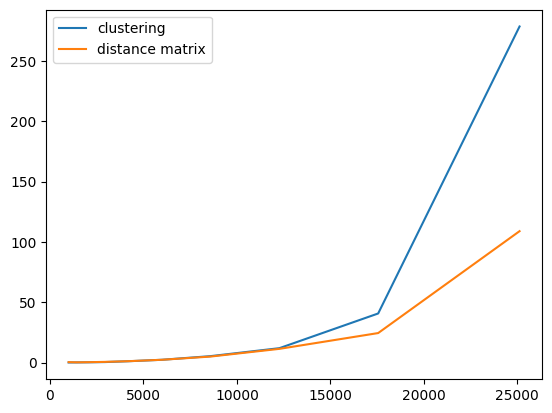

In [96]:
plt.plot(n_list, times_methods['hdbscan'], label="clustering")
plt.plot(n_list, times_mat, label="distance matrix")
# plt.plot(x, y)
plt.legend()
plt.show()

### HDBSCAN clustering

We repeatedly cluster a random sample of 20.000 neurons to get an idea of the behaviour of the algorithm on the data:

In [97]:
label_list = []
for i in range(20):
	print(f"{i+1}/20  ", end="\r")
	subsample = activation_samples[np.random.choice(len(activation_samples), 20000)]
	dm = main.compute_distance_matrix(subsample)
	cluster = HDBSCAN(metric='precomputed')
	cluster.fit(dm)
	label_list += [cluster.labels_]

In [99]:
import pickle
with open('label_list.pickle', 'wb') as f:
	pickle.dump(label_list, f)

In [128]:
label_list = pickle.loads(Path('label_list.pickle').read_bytes())

The number of clusters (one of which is the group of outliers) and the number of outliers for each iteration:

In [24]:
for labels in label_list
	labels, counts = np.unique(cluster.labels_, return_counts=True)

In [102]:
data = np.vstack([
	[len(set(labels)) for labels in label_list],
	[sum(labels==-1) for labels in label_list]
])
pd.DataFrame(data, index=["num clusters", "num outliers"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
num clusters,173,3,168,3,3,3,181,4,3,197,174,5,4,166,196,3,3,185,4,179
num outliers,17605,5793,17532,1,5468,1,17740,1,1,17522,17533,7203,1,17824,18015,2799,4307,18001,1,17646


The distribution over the clusters in iterations with a small number of clusters

In [121]:
data = {
	i:
	list(np.unique(labels, return_counts=True)[1]) + ['']*(6-size)
	for i, labels in enumerate(label_list) if (size := len(set(labels))) < 6
}
pd.DataFrame([*data.values()],
		     index=data.keys(),
			 columns=["outliers"] + ['']*5)

,outliers,,,,,
1,5793,14201,6,,,
3,1,19994,5,,,
4,5468,14525,7,,,
5,1,19992,7,,,
7,1,9,19983,7,,
8,1,19994,5,,,
11,7203,5,6,12778,8,
12,1,8,19986,5,,
15,2799,17195,6,,,
16,4307,15688,5,,,


In [4]:
import numpy as np

def compute_distance_matrix(activations):
    with np.errstate(invalid='ignore'):
        correlations = np.nan_to_num(np.corrcoef(activations), copy=False)
    np.fill_diagonal(correlations, 1)
    assert not (correlations < -1).any() or (1 < correlations).any()
    return np.sqrt(1 - correlations*correlations)

In [131]:
from importlib import reload
reload(genieclust)

n_list = np.linspace(1000, 10000, num=10).astype(int)
times_mat, times_methods, cluster_info = time_clustering_methods(
	{'genie': Genie(affinity='precomputed', exact=False).fit_predict},
	activation_samples, n_list,
	tries_list=np.linspace(6, 1, num=10).astype(int)
)

ValueError: Package `nmslib` is not available.

In [126]:
import nmslib

Your CPU supports instructions that this binary was not compiled to use: AVX2
For maximum performance, you can install NMSLIB from sources 
pip install --no-binary :all: nmslib
